<a href="https://colab.research.google.com/github/ajrodenburg/instrument_recognition/blob/Jeroen/instrument_recognition_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = #003399> **Instrument recognition** </font>


## <font color = "purple"> **Initialize** </font>


### <font color = "green"> **Import packages** </font>

In [1]:
import os       # For path-manipulations etc

import librosa  # For all kinds of audio manipulations
from librosa import display

from IPython.display import Audio #to play audio inside the notebook

import numpy as np
import scipy
import matplotlib.pyplot as plt

### <font color = "green"> **Mount google drive** </font>

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFLI8Rjkn0A73wPGAgM7OuM7ozqVzeMoDAjmulNDI1KZBr6-SnGzAw
Mounted at /content/drive


## <font color="purple"> **Import data** </font>

In [3]:
def import_data(data_dir, ins_annotations, max_songs_per_annotation = None):
  """
  Imports the data.

  Parameters
  ----------

  data_dir : string
    Path of the directory that contains the data. It is assumed that 
    this directory contains subdirectories, whose titles are given by
    the annotations of the various instruments. The actual sound-files 
    are inside these subfolders.

  ins_annotations : array of strings
    List of the annotations of the various annotations - these strings 
    also the names of the subfolders that contain the data with that 
    annotation.

  max_songs_per_annotations : int, optional
    Maximum number of songs to include per annotation. Useful to test my code
    while working only a smaller dataset.

  Returns
  -------

  sampling_rates : np.array of ints
    List of the sample-rates (in Hz) of all the music-files

  data : list of np.arrays
    List of time-domain data (in np.array format) of all music snippets.

  classifications : np.array of strings
    List of the annotation for every song - the annotation is for
    the predominant instrument.

  """

  # Initalize the to-be-returned np.arrays
  sampling_rates = [] #note: I'm choosing this to be a list, not a np.arrary.
                    #The reaons is not very good -  but it seems easier to 
                    # append integers to a list. 
                    # If I were to intiialize sampling_rates as a np.array, 
                    # every entry of sampling_rates is automatically treated
                    # as float64..
  data = [] # note: its type is list, not np.array, because the data-signals 
            # it contains may - in principle - be of different length
  classifications = np.array([])

  # Import:
  for annotation in ins_annotations:

    print(f"\nImporting data with annotation '{annotation}'")
    data_subdir = os.path.join(data_dir,annotation)
    list_filenames = os.listdir(data_subdir)

    # Initialize counter that counts how many files are imported with this
    # annotation --  used only to print this number during the importing.
    counter = 0

    for filename in list_filenames[:max_songs_per_annotation]:

      dt, sr = librosa.load( os.path.join(data_subdir,filename), sr = None, mono = False )

      data.append(dt)
      sampling_rates.append( int(sr) )
      classifications = np.append(classifications,annotation)

      # print the number of imported snippets so far:
      counter = counter + 1
      print(f"\rImported snippets: {counter} of {len(list_filenames)}", end = '')

  return sampling_rates, data, classifications

In [4]:
# Set working directory for this project
base_dir = '/content/drive/My Drive/Colab Notebooks/instrument_recognition'
os.chdir(base_dir)

# Data directory:
data_dir = os.path.join(base_dir,'data','IRMAS','trainingdata')
# List of the strings used as instrument annotations
ins_annotations = ['cel','cla','flu','gac','gel','org','pia','sax','tru','vio','voi']

#Import data
sampling_rates, data, y = import_data(data_dir, ins_annotations, max_songs_per_annotation = None)


Importing data with annotation 'cel'
Imported snippets: 388 of 388
Importing data with annotation 'cla'
Imported snippets: 505 of 505
Importing data with annotation 'flu'
Imported snippets: 451 of 451
Importing data with annotation 'gac'
Imported snippets: 637 of 637
Importing data with annotation 'gel'
Imported snippets: 760 of 760
Importing data with annotation 'org'
Imported snippets: 121 of 682

KeyboardInterrupt: ignored

## <font color="purple"> **Preprocessing** </font>

**Features**: The first *n_mfcc* mel-frequency cepstral coefficients, time-averaged over all time-windows. *n_mfcc* can be specified.  

### <font color = "green"> **Supporting functions** </font>


In [ ]:
def obtain_average_mfccs(data, sampling_rates, window_time, time_step = None, n_mfcc = 20):
  """
  Obtains, for every time-profile in 'data', the MFCC's (averaged over all time-windows) 

  Parameters
  ----------

  data : list of m np.arrays of shape 2 x something
    Here m is the number of snippets. Every entry of data contains the time-series of a single music snippet, 
    which is assumed to be stereo.

  sampling_rates : list of m ints
    Every int is the sample rate of the corresponding entry in data.

  window_time : float
    Length in seconds of a window to be used in the short-time Fourier transform,
    that is part of the mfcc-routine.

  time_step : float, optional
    Length in seconds of the time step between two successive windows.
    If not provided, it is set to window_time/2.

  n_mfcc : int
    Number of to-be-returned mel-frequency cepstral coefficients per snippet.

  Returns
  -------

  average_mfccs : np.array of shape m x 2 x n_mfcc
    Every entry of this list corresponds to one entry of data, and contains 
    the mfcc's averaged of the left- and right-component of the stereo signal.
  """

  # If time_step is not defined, give it a standard value:
  if time_step == None:
    time_step = window_time / 2
    print(f'The time-step is not specifed and therefore set to the standard value: window_time/2 = {time_step}')

  # Define useful variable:
  m = len(data)

  # Initialize the to-be-returned np.array of average mfccs
  average_mfccs = np.zeros((m,2,n_mfcc))

  # Loop over data samples (snippets), 
  # and calculate the average mfcc's for every sample
  for i in range(m):
    # Parameters for dividing total time sample into windows:
    ## Length of a window
    n_fft = int(np.ceil(sampling_rates[i]*window_time)) 
    ## Hop length between two successive windows
    hop_length = int(np.ceil(sampling_rates[i]*time_step))

    # Calculate the mffc for the left- and right-audio
    mfccs_left = librosa.feature.mfcc(data[i][0], sr = sampling_rates[i], n_fft = n_fft, hop_length = hop_length)
    mfccs_right = librosa.feature.mfcc(data[i][1], sr = sampling_rates[i], n_fft = n_fft, hop_length = hop_length)

    # Average mfccs over all time-windows,
    # and store result in average_mfccs:
    average_mfccs[i,0] = np.mean(mfccs_left,axis=1)
    average_mfccs[i,1] = np.mean(mfccs_right,axis=1)

    print(f'\rNumber of average mfccs obtained: {i+1} out of {m}', end = '')

  return average_mfccs

In [ ]:
def standardize(X, axis = None):
  """
  `Standardizes' the elements of a 2D array: 
  To every entry we substract the mean of its column
  and divide by the standard-deviation of its column.

  Parameters
  ----------

  X : np.array of shape (m,n) for ints m, n
    To-be-standardized array

  Returns
  -------
  X_std : np.array of shape (m,n)
    Standardized array
  """

  # Compute mean and standarddeviation for every column:
  mu = np.mean(X, axis = 0)
  sigma = np.std(X, axis = 0)

  # For every element of array: 
  # substract mean and divide by standarddeviation
  X_std = (X - mu)/sigma
  ## Note that the shapes of array, mu and sigma do not match,
  ## but the broadcasting property of the python operations '-'
  ## and '/' ensures that it works as it should.

  return X_std

### <font color = "green"> **Perform the preprocessing** </font>

**Remark on splitting of the data**: I'm using the IRMAS 'trainingdataset' as my **entire** dataset - which I will split into training, cross-validation and testingsets. This is the simplest thing to do right now. They also provide 'trainingdata', but it's of a different format than their trainingdata (longer snippets etc). It's interesting to test a trained classifier on that too - but a bit more complicated. For now, let's do the simplest thing possible.

In [ ]:
def preprocess_using_mfccs(data, sampling_rates, y,\
                           window_time, time_step = None, n_mfcc = 20,\
                           fraction_train = 0.6, fraction_test = 0.2):
  '''
  Takes the time-data, its sampling rates and its labels, and performs 
  the preprocessing: it returns the data and labels ready to be used for
  machine learning algorithms. As features it uses, for every snippet, its
  n_mfcc first time-averaged mfccs. It also separates the data into training, 
  cross-validation, and testdata. And it standardizes the features, i.e.
  it makes sure that distribution of every coefficient has zero mean and unit
  variance.

  Parameters
  ----------

  data : list of m np.arrays of shape 2 x something
    Here m is the number of snippets, and `something' the number of 
    time-samples of a single snippet. Every entry of data contains 
    the time-series of a single music snippet, which is assumed to be stereo.
  
  y : list of m strings.
    y[i] is the annotation that corresponds to the snippet encoded by data[i].

  sampling_rates : list of m ints
    Every int is the sample rate of the corresponding entry in data.

  window_time : float
    Length in seconds of a window to be used in the short-time Fourier transform,
    that is part of the mfcc-routine.

  time_step : float, optional
    Length in seconds of the time step between two successive windows.
    If not provided, it is set to window_time/2.

  n_mfcc : int, optional
    Number of to-be-returned mel-frequency cepstral coefficients per snippet.
    Standard value is 20.

  fraction_train : float, s.t. 0 <= fraction_train <= 1.
    Fraction of the total dataset to be used as trainingset.
  
  fraction_CV : float, s.t. 0 <= fraction_CV <= 1 - fraction_train.
    Fraction of the total dataset to be used as trainingset.

  Returns
  -------

  X_train_std : np.array of shape (m_train, n_mfcc)
    Standardized training data. 
    Standardized means that every subset X_train[:,n_mfcc] was:
      1. Shifted s.t. its mean = 0.
      2. Normalized s.t. its standarddeviation = 1.
  
  X_CV_std : np.array of shape (m_CV, n_mfcc)
    Standardized cross-validation data.

  X_test_std : np.array of shape (m_test, n_mfcc)
    Standardized testdata.

  y_train : np.array of shape (m_train,)
    Labels of training data.

  y_CV : np. array of shape (m_CV,)
    Labels of cross-validation data.

  y_test : np.array of shape (m_test,)
    Labels of testdata.
  '''

  # Steps:
  # (1) Obtain the time-averaged mfccs of every sample.
  # (2) Reshape the resulting list of our stereo-data into more suitable format.
  # (3) Split into training, cross-validation and testset.
  # (4) Standardize features.

  # Useful variable:
  m = len(data)

  # Step (1): Obtain the time-averaged mfccs of every sample.
  average_mfccs = obtain_average_mfccs(data, sampling_rates, window_time = 0.030)

  # Step (2): Reshape the resulting list of our stereo-data into more suitable format.
  X = np.reshape(average_mfccs,(m,2*n_mfcc))

  # Step (3): Split into training, cross-validation and testset.
  ## Before splitting, we shuffle X & y:
  from sklearn.utils import shuffle
  X_shuffled, y_shuffled = shuffle(X,y)

  ## Now, we split:

  ### Define the fractions of the data to be used
  ### for training, and cross-validation (CV); 
  ### the remainder will be the testing fraction:

  fraction_train = 0.6
  fraction_CV    = 0.2

  ### Number of samples for training, CV and testing:
  m_train = int( np.ceil( fraction_train * m ) )
  m_CV    = int( np.ceil( fraction_CV * m  ) )
  m_test  = m - m_train - m_CV

  ### Split

  X_train = X_shuffled[:m_train]
  X_CV    = X_shuffled[m_train:(m_train+m_CV)]
  X_test  = X_shuffled[-m_test:]

  y_train = y_shuffled[:m_train]
  y_CV    = y_shuffled[m_train:(m_train+m_CV)]
  y_test  = y_shuffled[-m_test:]

  # Step (4): Standarddize all features.

  X_train_std = standardize(X_train)
  X_CV_std = standardize(X_CV)
  X_test_std = standardize(X_test)

  return X_train_std, X_CV_std, X_test_std, y_train, y_CV, y_test

In [ ]:
X_train_std, X_CV_std, X_test_std, y_train, y_CV, y_test = \
  preprocess_using_mfccs(data, sampling_rates, y,\
                         window_time = 0.030, time_step = None, n_mfcc = 20,\
                         fraction_train = 0.6, fraction_test = 0.2)

The time-step is not specifed and therefore set to the standard value window_time/2 = 0.015
Number of average mfccs obtained: 6705 out of 6706

## <font color = "purple"> **Machine-learning** </font>

Let's try a few different classifiers with different algorithms, and compare them. Let's start as simple as possible.



### <font color = "green"> **Simple logistic regression** </font>

In [ ]:
from sklearn.linear_model import LogisticRegression

#### <font color = '#CC3300'> **Compare different regularization parameters** </font>

##### <font color = 'blue'> **Supporting functions** </font>

In [ ]:
def evaluate_performance_LR(X_train_std, y_train, X_CV_std, y_CV, C):
  '''
  Trains a Logistic-Regression-Classifier on a trainingset, 
  and returns its accuracy on the trainingset, as well as on a separate set
  (cross-validation or test-set)

  Parameters
  ----------

  X_train_std : np.array of shape (m_train,n_train)
    Training data of m_train training samples and n_train standardized features.

  y_train : np.array of shape (m_train,)
    Labels of training set

  X_CV_std : np.array of shape (m_CV,n_CV)
    Cross-validation or testing data of m_CV training samples
    and n_CV standardized features.

  y_CV : np.array of shape (m_CV,)
    Labels of cross-valdation or test set.

  C : float64 
    inverse regularization parameter

  Returns
  -------

  np.array([score_train,score_CV]), where:

  score_train : float 64 (where 0 <= score_train <=1 )
    Accuracy of the trained logistic-regression-model on the training set.

  score_CV : float 64 (where 0 <= score_CV <=1 )
    Accuracy of the trained logistic-regression-model 
    on the cross-validation/test set.
  '''

  # Initalize Logistic Regression model
  logisticRegr = LogisticRegression(C = C, max_iter = 1000)

  # Train it
  logisticRegr.fit(X_train_std, y_train)

  # Evaluate accuracies
  score_train = logisticRegr.score(X_train_std, y_train)
  score_CV    = logisticRegr.score(X_CV_std   , y_CV)

  return np.array([score_train,score_CV])

In [ ]:
def compare_regparams(X_train_std, y_train, X_CV_std, y_CV,\
                      C_list= np.array([0.001,0.003,0.01,0.03,0.1,0.3,\
                              1,3,10,30,100,300,1000])\
                      ):
  '''
  Evaluates the performance of the logistic regression classifier for several
  (inverse) regularaization parameters 'C'. Selects the best one by finding 
  the maximum accuracy on the cross-validation set. Returns the scores for 
  every C, the optimal C, and the optimal classifier.

  Parameters
  ----------

  X_train_std : np.array of shape (m_train,n_train)
    Training data of m_train training samples and n_train standardized features.

  y_train : np.array of shape (m_train,)
    Labels of training set

  X_CV_std : np.array of shape (m_CV,n_CV)
    Cross-validation or testing data of m_CV training samples
    and n_CV standardized features.

  y_CV : np.array of shape (m_CV,)
    Labels of cross-valdation or test set.

  C_list : np.array of float64's 
    inverse regularization parameter

  Returns
  -------

  np.array([score_train,score_CV]), where:

    score_train : float 64 (where 0 <= score_train <=1 )
      Accuracy of the trained logistic-regression-model on the training set.

    score_CV : float 64 (where 0 <= score_CV <=1 )
      Accuracy of the trained logistic-regression-model 
    on the cross-validation/test set.
  
  C_best : float64
    Optimal value of C, meaning that value of 'C_list' for which the accuracy 
    on the cross-validation set is maximal.

  LR_best : LogisticRegression-class or smth
    The optimal logistic regression model
  '''

  # Calculate scores for all C's:
  scores =\
    np.array( =\
      [ evaluate_performance_LR(X_train_std, y_train, X_CV_std, y_CV, C)\
       for C in Clist ]\
           )
  # Determine the C that gives the maximum score on the cross-validation set.
  ind_best = np.argmax(scores[:,1]) # for multiple max-values, it gives 
                                    # the first one, which is probably fine
  C_best = Clist[ind_best]

  # Define and train a logistic regression model with this best values of C.
  LR_best = LogisticRegression(C = C_best)
  LR_best.fit(X_train_std, y_train)

  return scores, C_best, LR_best

##### <font color = 'blue'> **Perform the comparison** </font>

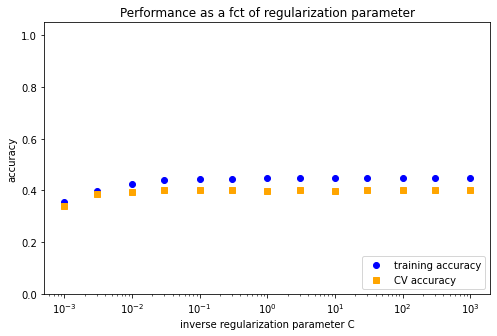

In [ ]:
# Compare different regularization parameters, and plot their performance
Clist = [0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000]
scores, C_best, LR_best =\
  compare_regparams(X_train_std, y_train, X_CV_std, y_CV, C_list= C_list)

plt.figure(figsize = (8,5))
plt.plot(Clist,scores[:,0],'bo')
plt.plot(Clist,scores[:,1],'bs', color = 'orange')
plt.xscale('log')
plt.ylim((0,1.05))
plt.xlabel('inverse regularization parameter C')
plt.ylabel('accuracy')
plt.title('Performance as a fct of regularization parameter')
plt.legend(('training accuracy', 'CV accuracy'), loc = 'lower right')

#Summary of the best regularization parameter and the performance of the LR.
## Determine scores
score_train = logisticRegr.score(X_train_std, y_train)
score_CV    = logisticRegr.score(X_CV_std   , y_CV)
score_test  = logisticRegr.score(X_test_std , y_test)

## Print summary
msg = (f'Simple logistic regression was found to work best\n'
       f'with the inverse regularization parameter C = {C_best},\n'
       f'and gave the accuracies:\n\n'
       f'score_train = {score_train:.2f},\n'
       f'score_CV    = {score_CV:.2f},\n'
       f'score_test  = {score_test:.2f}.' )

print(msg)